# **TGS Salt Identification Challenge**
### Segment salt deposits beneath the Earth's surface

## Competition Site

Description, Evaluation, and Data Set taken from the [competition site](https://www.kaggle.com/c/tgs-salt-identification-challenge).

## Description

![alt text](https://www.tgs.com/hubfs/Archives%202016-2019/2018/2018%20TGS/Mega%20Menu%20Data%20Library.png)

Several areas of Earth with large accumulations of oil and gas also have huge deposits of salt below the surface.

But unfortunately, knowing where large salt deposits are precisely is very difficult. Professional seismic imaging still requires expert human interpretation of salt bodies. This leads to very subjective, highly variable renderings. More alarmingly, it leads to potentially dangerous situations for oil and gas company drillers.

To create the most accurate seismic images and 3D renderings, [TGS (the world’s leading geoscience data company)](https://www.tgs.com/) is hoping Kaggle’s machine learning community will be able to build an algorithm that automatically and accurately identifies if a subsurface target is salt or not.

## Evaluation

This competition is evaluated on the mean average precision at different intersection over union  thresholds. The **IoU** of a proposed set of object pixels and a set of true object pixels is calculated as:

### $$\color{blue}{IoU(A, B)=\frac{A \cap B}{A \cup B}}$$

The metric sweeps over a range of IoU thresholds, at each point calculating an average precision value. The threshold values range from 0.5 to 0.95 with a step size of 0.05: (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95). In other words, at a threshold of 0.5, a predicted object is considered a "hit" if its intersection over union with a ground truth object is greater than 0.5.

At each threshold value **t**, a precision value is calculated based on the number of true positives **TP**, false negatives **FN**, and false positives **FP** resulting from comparing the predicted object to all ground truth objects:

### $$\color{blue}{\frac{TP(t)}{TP(t) + FP(t) + FN(t)}}$$

A true positive is counted when a single predicted object matches a ground truth object with an IoU above the threshold. A false positive indicates a predicted object had no associated ground truth object. A false negative indicates a ground truth object had no associated predicted object. The average precision of a single image is then calculated as the mean of the above precision values at each IoU threshold:

### $$\color{blue}{\frac{1}{|thresholds|}\sum_{t}\frac{TP(t)}{TP(t) + FP(t) + FN(t)}}$$

Lastly, the score returned by the competition metric is the mean taken over the individual average precisions of each image in the test dataset.

## Data Set
### Background
Seismic data is collected using reflection seismology, or seismic reflection. The method requires a controlled seismic source of energy, such as compressed air or a seismic vibrator, and sensors record the reflection from rock interfaces within the subsurface. The recorded data is then processed to create a 3D view of earth’s interior. Reflection seismology is similar to X-ray, sonar and echolocation.

A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. In theory, the strength of reflection is directly proportional to the difference in the physical properties on either sides of the interface. While seismic images show rock boundaries, they don't say much about the rock themselves; some rocks are easy to identify while some are difficult.

There are several areas of the world where there are vast quantities of salt in the subsurface. One of the challenges of seismic imaging is to identify the part of subsurface which is salt. Salt has characteristics that makes it both simple and hard to identify. Salt density is usually 2.14 g/cc which is lower than most surrounding rocks. The seismic velocity of salt is 4.5 km/sec, which is usually faster than its surrounding rocks. This difference creates a sharp reflection at the salt-sediment interface. Usually salt is an amorphous rock without much internal structure. This means that there is typically not much reflectivity inside the salt, unless there are sediments trapped inside it. The unusually high seismic velocity of salt can create problems with seismic imaging.

### Data
The data is a set of images chosen at various locations chosen at random in the subsurface. The images are 101 x 101 pixels and each pixel is classified as either salt or sediment. In addition to the seismic images, the depth of the imaged location is provided for each image. The goal of the competition is to segment regions that contain salt.



## Download dataset

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mylo2202","key":"6de40906d33ce9877d0bd17990ca7040"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c tgs-salt-identification-challenge

 94% 203M/217M [00:02<00:00, 92.6MB/s]
100% 217M/217M [00:02<00:00, 105MB/s] 
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 81.8MB/s]
  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 164MB/s]
 79% 30.0M/37.9M [00:00<00:00, 30.4MB/s]
100% 37.9M/37.9M [00:00<00:00, 95.9MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 128MB/s]
 89% 145M/163M [00:01<00:00, 64.2MB/s]
100% 163M/163M [00:02<00:00, 85.1MB/s]
 70% 29.0M/41.4M [00:00<00:00, 65.5MB/s]
100% 41.4M/41.4M [00:00<00:00, 87.8MB/s]


In [ ]:
!unzip -q train.zip -d train
!unzip -q test.zip -d test

## Import Library

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from skimage.transform import resize

from tqdm import tqdm_notebook
from tqdm.auto import trange, tqdm

import tensorflow as tf
# from tensorflow import keras
from keras.layers import Layer, Input, Activation
from keras import backend as K
from keras import utils
from keras.models import Model, load_model
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate, add
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array, load_img

from tensorflow.keras import layers

## Preprocessing data and split data

Lets see the number of images in each file:

In [ ]:
data_dir = '/content'
print('Number images in train data: ', len(os.listdir(data_dir + '/train/images')))
print('Number maskes in train data: ', len(os.listdir(data_dir + '/train/masks')))
print('Number images in test data: ', len(os.listdir(data_dir + '/test/images')))

Number images in train data:  4000
Number maskes in train data:  4000
Number images in test data:  18000


In [ ]:
train_mask = pd.read_csv('/content/train.csv')
depth = pd.read_csv('/content/depths.csv')
train_path = "./"
file_list = list(train_mask['id'].values)
len(file_list)

4000

Load image, resize shape from (101, 101, 1) to (128, 128, 1) and normalize values of pixel from (0,255) to (0, 1)

In [ ]:
X = np.zeros((len(file_list), 128, 128, 1), dtype=np.float32)
y = np.zeros((len(file_list), 128, 128, 1), dtype=np.float32)

for n, id_ in tqdm_notebook(enumerate(train_mask['id']), total=len(file_list)):
    img = load_img("/content/train/images/" + id_ + '.png', grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("/content/train/masks/" + id_ + '.png', grayscale=True))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/65535.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Because the number of images in the trainset is less than that in the testset so I generated image in trainset after split train data and validation data to evaluation model.

In [ ]:
X_train = X[:int(0.85*len(X))]
y_train = y[:int(0.85*len(X))]
X_val  = X[int(0.85*len(X)):]
y_val  = y[int(0.85*len(X)):]

X_train = np.append(X_train, [np.fliplr(x) for x in X], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y], axis=0)
X_train = np.append(X_train, [np.flipud(x) for x in X], axis=0)
y_train = np.append(y_train, [np.flipud(x) for x in y], axis=0)

print('X train shape:', X_train.shape, 'X eval shape:', X_val.shape)
print('Y train shape:', y_train.shape, 'Y eval shape:', y_val.shape)

X train shape: (11400, 128, 128, 1) X eval shape: (600, 128, 128, 1)
Y train shape: (11400, 128, 128, 1) Y eval shape: (600, 128, 128, 1)


## Visualization image

4323


Text(0.5, 1.0, 'Salt')

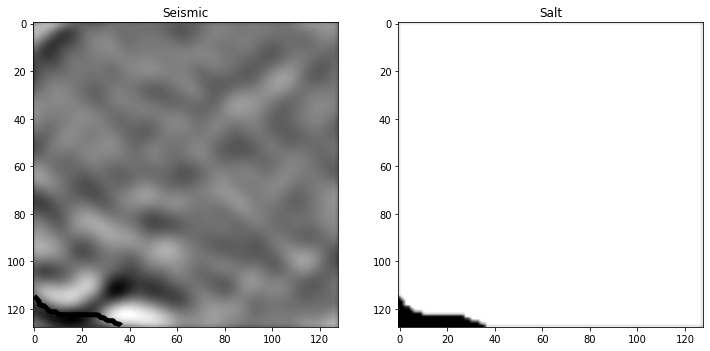

In [ ]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
print(ix)
has_mask = y_train[ix].max() > 0 # salt indicator

fig, ax = plt.subplots(1, 2, figsize = (12, 8))

ax[0].imshow(X_train[ix, ..., 0], cmap = 'gray', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax[0].contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax[1].set_title('Salt')

## Loss function,  Metric Evaluation and Helper Func

In [ ]:
from tensorflow.keras.losses import binary_crossentropy

# F1-score or Dice coef
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())

In [ ]:
def iou_metric(labels, y_pred):
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        prec.append(p)
    return np.mean(prec)

def iou_metric_batch(labels, y_pred):
    batch_size = labels.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(labels[batch], y_pred[batch])
        metric.append(value)
    return np.mean(metric)

In [ ]:
def evaluaWithVal(mod, X_val, y_val):
    preds_eval = mod.predict(X_val, verbose=1)

    thresholds = np.linspace(0, 1, 50)
    ious = np.array([iou_metric_batch(y_val, np.int32(preds_eval > threshold)) for threshold in tqdm(thresholds)])

    threshold_best_index = np.argmax(ious[9:-10]) + 9
    iou_best = ious[threshold_best_index]
    threshold_best = thresholds[threshold_best_index]

    plt.plot(thresholds, ious)
    plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
    plt.xlabel("Threshold")
    plt.ylabel("IoU")
    plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
    plt.legend();

    return threshold_best

In [ ]:
def buildModel(mod, summary= False, plot_model= False):
    input_img = Input((128, 128, 1))
    model = mod(input_img)
    model.compile(optimizer= Adam(learning_rate= 0.005), loss= binary_crossentropy, metrics= [dice_coefficient])
    if summary == True:
        model.summary()
    if plot_model == True:
        utils.plot_model(model, expand_nested=True, show_shapes=True)
        
    return model

## Unet v1: Basic Unet

![alt text](https://imgur.com/lKZGO0C.png)

In [ ]:
def conv_block(tensor, n_filter, kernel_size = 3, batchnorm= True):
    # Conv layer 1
    x = Conv2D(n_filter, kernel_size= (kernel_size, kernel_size), padding= 'same')(tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Conv layer 2
    x = Conv2D(n_filter, kernel_size= (kernel_size, kernel_size), padding= 'same')(tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [ ]:
def encode_block(tensor, n_filter, kernel_size = 3, batchnorm= True, drop= 0.2):
    # Conv Block
    conv = conv_block(tensor= tensor, n_filter= n_filter, kernel_size= kernel_size, batchnorm= batchnorm)
    # Max Pooling layer
    res = MaxPooling2D((2, 2))(conv)
    res = Dropout(drop)(res)
    return conv, res

In [ ]:
def decode_block(input_layer, concat_layer, n_filter, kernel_size = 3, batchnorm= True, drop= 0.15):
    convtrans = Conv2DTranspose(filters= n_filter, kernel_size= (kernel_size, kernel_size),
                        strides= (2, 2), padding= 'same')(input_layer)
    convtrans = concatenate([convtrans, concat_layer])
    convtrans = Dropout(drop)(convtrans)
    dec = conv_block(convtrans, n_filter= n_filter, kernel_size= kernel_size, batchnorm= batchnorm)

    return dec

In [ ]:
def Unetv1(input_image):
    # Left U
    conv1, res1 = encode_block(input_image, 16, kernel_size= 3, batchnorm= True, drop = 0.1)
    conv2, res2 = encode_block(res1, 32, kernel_size= 3, batchnorm= True, drop = 0.1)
    conv3, res3 = encode_block(res2, 64, kernel_size= 3, batchnorm= True, drop = 0.1)
    conv4, res4 = encode_block(res3, 128, kernel_size= 3, batchnorm= True, drop = 0.1)
    conv5 = conv_block(res4, 256, kernel_size= 3, batchnorm= True)

    # Right U
    dec1 = decode_block(conv5, conv4, n_filter= 128, kernel_size= 3, batchnorm= True, drop= 0.1)
    dec2 = decode_block(dec1, conv3, n_filter= 64, kernel_size= 3, batchnorm= True, drop= 0.1)
    dec3 = decode_block(dec2, conv2, n_filter= 32, kernel_size= 3, batchnorm= True, drop= 0.1)
    dec4 = decode_block(dec3, conv1, n_filter= 16, kernel_size= 3, batchnorm= True, drop= 0.1)

    # Output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(dec4)
    model = Model(inputs=[input_image], outputs=[outputs])

    return model

In [ ]:
modelUnetv1= buildModel(Unetv1)

In [ ]:
# Callbacks func
callbacks = [
    EarlyStopping(patience=20, verbose=1),
    ReduceLROnPlateau(mode='max',factor=0.3, patience=7, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = modelUnetv1.fit(X_train, y_train, batch_size= 32, epochs=100, callbacks=callbacks,\
                    validation_data=(X_val, y_val))

Epoch 1/100
357/357 [==============================] - 59s 68ms/step - loss: 0.4562 - dice_coefficient: 0.4574 - val_loss: 1.4763 - val_dice_coefficient: 0.5029

Epoch 00001: val_loss improved from inf to 1.47633, saving model to model-tgs-salt.h5
Epoch 2/100
357/357 [==============================] - 23s 65ms/step - loss: 0.3038 - dice_coefficient: 0.6244 - val_loss: 0.3173 - val_dice_coefficient: 0.7275

Epoch 00002: val_loss improved from 1.47633 to 0.31730, saving model to model-tgs-salt.h5
Epoch 3/100
357/357 [==============================] - 23s 65ms/step - loss: 0.2745 - dice_coefficient: 0.6614 - val_loss: 0.3036 - val_dice_coefficient: 0.6857

Epoch 00003: val_loss improved from 0.31730 to 0.30355, saving model to model-tgs-salt.h5
Epoch 4/100
357/357 [==============================] - 23s 64ms/step - loss: 0.2500 - dice_coefficient: 0.6900 - val_loss: 0.2592 - val_dice_coefficient: 0.6855

Epoch 00004: val_loss improved from 0.30355 to 0.25924, saving model to model-tgs-salt

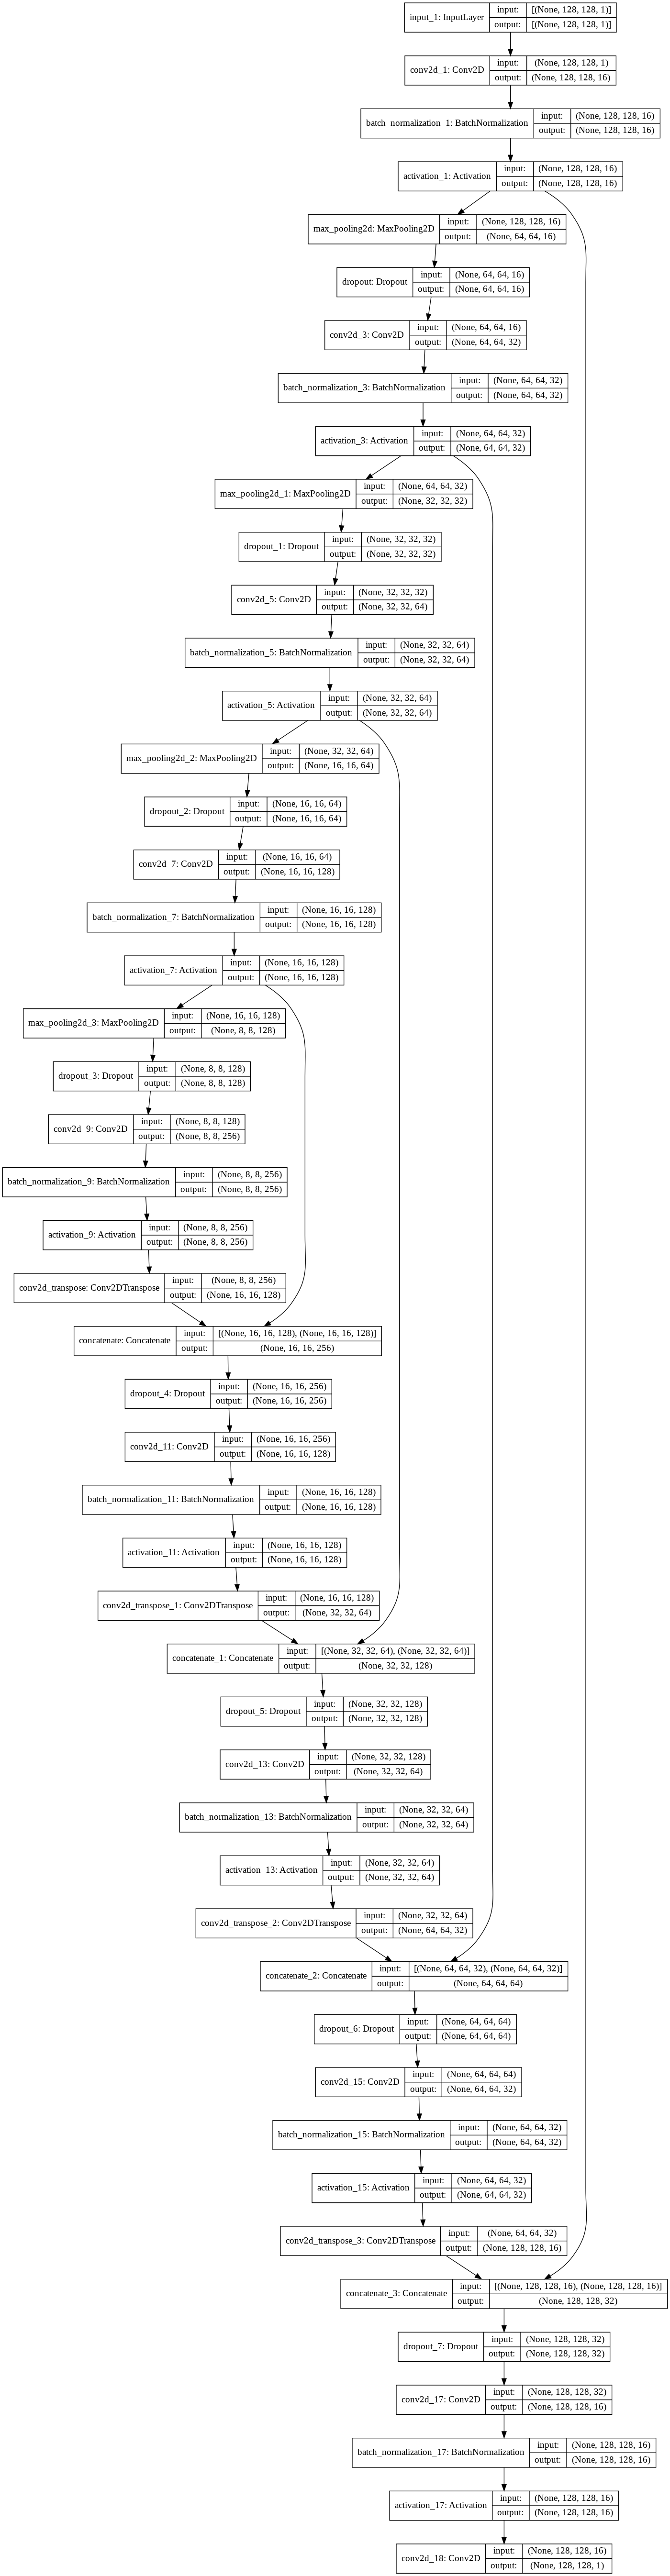

In [ ]:
utils.plot_model(modelUnetv1, expand_nested=True, show_shapes=True)

dict_keys(['loss', 'dice_coefficient', 'val_loss', 'val_dice_coefficient', 'lr'])


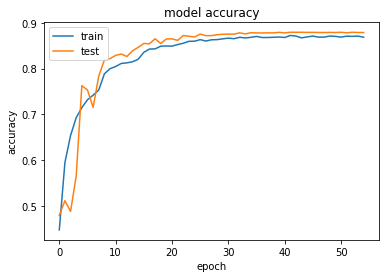

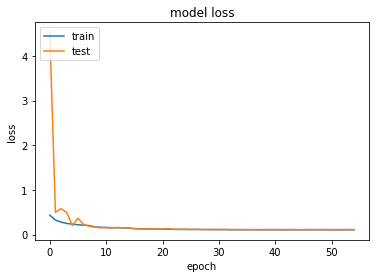

In [ ]:
# list all data in history
print(results.history.keys())

# summarize history for accuracy
plt.plot(results.history['dice_coefficient'])
plt.plot(results.history['val_dice_coefficient'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

19/19 [==============================] - 1s 18ms/step


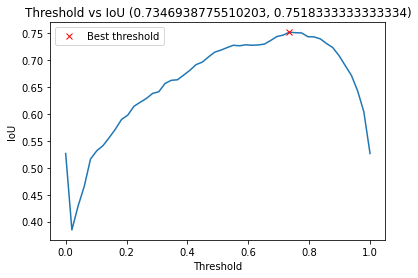

In [ ]:
threshold_best = evaluaWithVal(modelUnetv1, X_val, y_val)

## Unet v2: Add residual block

In [ ]:
def conv_block_v2(tensor, n_filter, kernel_size = 3, batchnorm= True):
    # Conv layer 1
    conv = Conv2D(n_filter, kernel_size= (kernel_size, kernel_size), padding= 'same')(tensor)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    # Conv layer 2
    conv = Conv2D(n_filter, kernel_size= (kernel_size, kernel_size), padding= 'same')(tensor)
    # conv = Conv2D(n_filter, kernel_size= (kernel_size, kernel_size), padding= 'same')(conv)
    if batchnorm:
        conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)

    return conv

In [ ]:
def residual_block(tensor, n_filter, kernel_size = 3, connect=True, pool=True, batchnorm= True, drop= 0.2):
    # Conv Block
    res = conv_block_v2(tensor, n_filter= n_filter, kernel_size= kernel_size, batchnorm= True)
    res = conv_block_v2(res, n_filter= n_filter, kernel_size= kernel_size, batchnorm= False)
    # skip_connected
    if connect:
        res = layers.Add()([res, tensor])
    if batchnorm:
        res = BatchNormalization()(res)
    res = Activation('relu')(res)
    if pool:
        res = MaxPooling2D((2, 2))(res)
        res = Dropout(drop)(res)

    return res

In [ ]:
def decode_block_v2(input_layer, concat_layer, n_filter, kernel_size = 3, batchnorm= True, drop= 0.15):
    convtrans = Conv2DTranspose(filters= n_filter, kernel_size= (kernel_size, kernel_size),
                        strides= (2, 2), padding= 'same')(input_layer)
    convtrans = concatenate([convtrans, concat_layer])
    convtrans = Dropout(drop)(convtrans)
    dec = conv_block_v2(convtrans, n_filter= n_filter, kernel_size= kernel_size, batchnorm= batchnorm)
    return dec

In [ ]:
def Unetv2(input_image):
    # Left U
    conv1 = conv_block_v2(input_image, 16, kernel_size= 3)
    res1 = residual_block(conv1, 16, kernel_size = 3, connect= False, pool= False, batchnorm= False)
    res1 = residual_block(res1, 16, kernel_size = 3, pool= True) # 64*64*16

    conv2 = conv_block_v2(res1, 32, kernel_size= 3)
    res2 = residual_block(conv2, 32, kernel_size = 3, connect= False, pool= False, batchnorm= False)
    res2 = residual_block(res2, 32, kernel_size = 3, pool= True) # 32*32*32

    conv3 = conv_block_v2(res2, 64, kernel_size= 3)
    res3 = residual_block(conv3, 64, kernel_size = 3, connect= False, pool= False, batchnorm= False)
    res3 = residual_block(res3, 64, kernel_size = 3, pool= True) # 16*16*64

    conv4 = conv_block_v2(res3, 128, kernel_size= 3)
    res4 = residual_block(conv4, 128, kernel_size = 3, connect= False, pool= False, batchnorm= False)
    res4 = residual_block(res4, 128, kernel_size = 3, pool= True) # 8*8*128

    conv5 = conv_block_v2(res4, 256, kernel_size= 3, batchnorm= True) # 8*8*256
    conv5 = layers.MaxPooling2D((2, 2))(conv5)
    conv5 = layers.Dropout(0.2)(conv5)
    

    # # Right U
    dec1 = decode_block_v2(conv5, res4, n_filter= 128, kernel_size= 3, batchnorm= True, drop= 0.1)
    dec2 = decode_block_v2(dec1, res3, n_filter= 64, kernel_size= 3, batchnorm= True, drop= 0.1)
    dec3 = decode_block_v2(dec2, res2, n_filter= 32, kernel_size= 3, batchnorm= True, drop= 0.1)
    dec4 = decode_block_v2(dec3, res1, n_filter= 16, kernel_size= 3, batchnorm= True, drop= 0.1)
    dec5 = decode_block_v2(dec4, conv1, n_filter= 8, kernel_size= 3, batchnorm= True, drop= 0.1)
    # # Output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(dec5)
    model = Model(inputs=[input_image], outputs=[outputs])

    return model

In [ ]:
modelUnetv2 = buildModel(Unetv2)

In [ ]:
# Callbacks func
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(mode='max',factor=0.3, patience=7, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results_2 = modelUnetv2.fit(X_train, y_train, batch_size= 32, epochs=100, callbacks=callbacks,\
                    validation_data=(X_val, y_val))

Epoch 1/100
357/357 [==============================] - 45s 115ms/step - loss: 0.4134 - dice_coefficient: 0.4673 - val_loss: 1.0152 - val_dice_coefficient: 0.5561

Epoch 00001: val_loss improved from inf to 1.01522, saving model to model-tgs-salt.h5
Epoch 2/100
357/357 [==============================] - 39s 109ms/step - loss: 0.3039 - dice_coefficient: 0.6217 - val_loss: 0.3414 - val_dice_coefficient: 0.6009

Epoch 00002: val_loss improved from 1.01522 to 0.34138, saving model to model-tgs-salt.h5
Epoch 3/100
357/357 [==============================] - 39s 109ms/step - loss: 0.2618 - dice_coefficient: 0.6768 - val_loss: 0.4630 - val_dice_coefficient: 0.6580

Epoch 00003: val_loss did not improve from 0.34138
Epoch 4/100
357/357 [==============================] - 39s 110ms/step - loss: 0.2432 - dice_coefficient: 0.7061 - val_loss: 0.2125 - val_dice_coefficient: 0.7264

Epoch 00004: val_loss improved from 0.34138 to 0.21254, saving model to model-tgs-salt.h5
Epoch 5/100
357/357 [==========

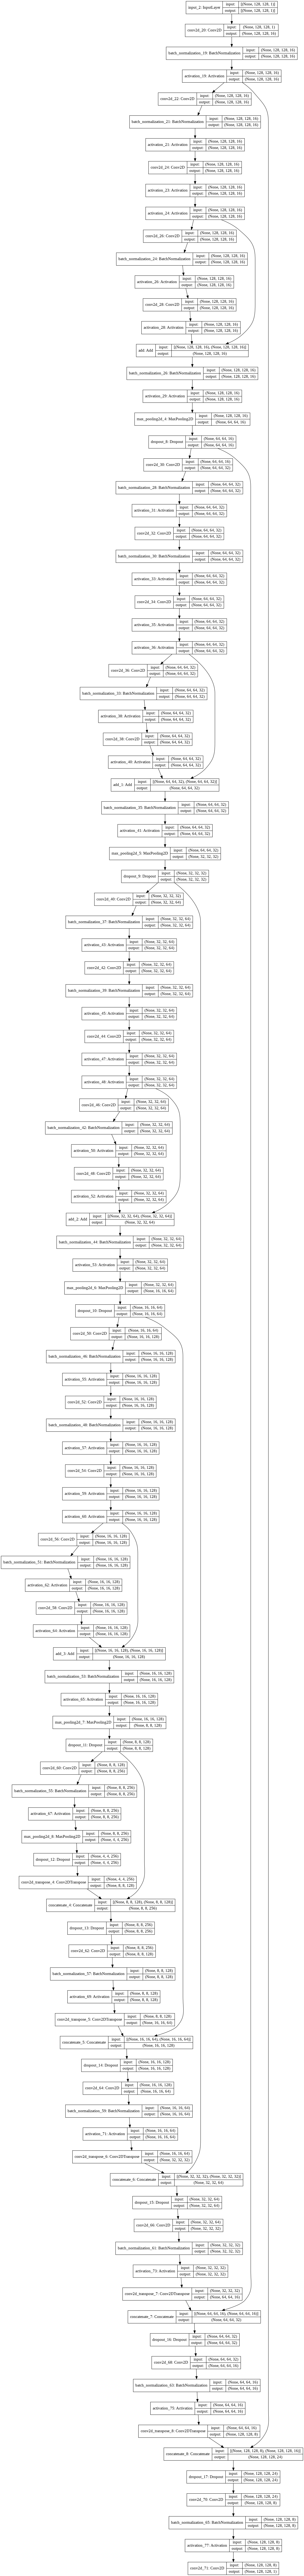

In [ ]:
utils.plot_model(modelUnetv2, expand_nested=True, show_shapes=True)

dict_keys(['loss', 'dice_coefficient', 'val_loss', 'val_dice_coefficient', 'lr'])


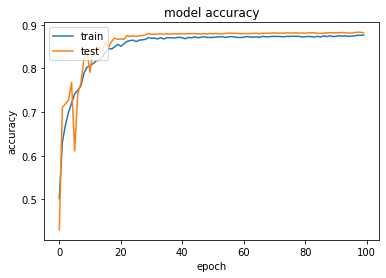

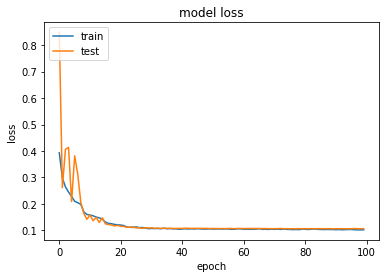

In [ ]:
# list all data in history
print(results_2.history.keys())

# summarize history for accuracy
plt.plot(results_2.history['dice_coefficient'])
plt.plot(results_2.history['val_dice_coefficient'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results_2.history['loss'])
plt.plot(results_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

19/19 [==============================] - 1s 31ms/step


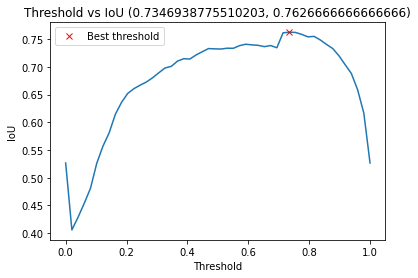

In [ ]:
threshold_best_2 = evaluaWithVal(modelUnetv2, X_val, y_val)

## Test model with validation dataset

In [ ]:
def evaluateModel(mod, X_train, X_val, y_val, threshold_best):
    # Evaluate with Validation set
    eva = modelSegNetv2.evaluate(X_val, y_val, verbose=1)
    print(eva)
    
    # Predicted
    preds_train = modelSegNetv2.predict(X_train, verbose=1)
    preds_val = modelSegNetv2.predict(X_val, verbose=1)
    
    # Threshold predictions
    preds_train_t = (preds_train > threshold_best).astype(np.uint8)
    preds_val_t = (preds_val > threshold_best).astype(np.uint8)
    
    return preds_train, preds_val, preds_train_t, preds_val_t

In [ ]:
preds_train, preds_val, preds_train_t, preds_val_t = evaluateModel(modelUnetv2, X_train, X_val, y_val, threshold_best_2)

19/19 [==============================] - 1s 27ms/step - loss: 0.1117 - dice_coefficient: 0.8790
[0.1117006316781044, 0.8789668083190918]
19/19 [==============================] - 0s 23ms/step


In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(11, 6))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

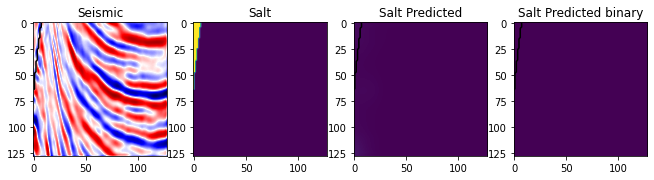

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=1234)

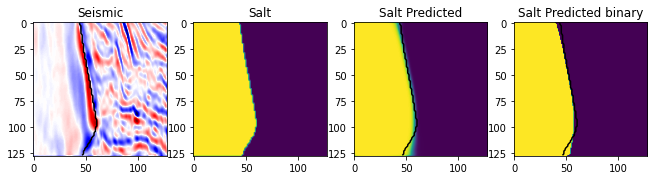

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t, ix= 2801)

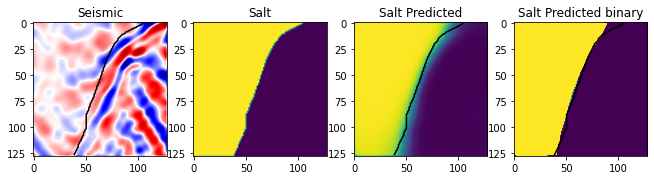

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t, ix= 49)

## Model predicted for test set and submit code

In [ ]:
test_dir = os.listdir('/content/test/images')
X_test = np.zeros((len(test_dir), 128, 128, 1), dtype=np.float32)
sizes_test = []

for n, id_ in tqdm_notebook(enumerate(test_dir), total=len(test_dir)):
    img = load_img("/content/test/images/" + id_ , grayscale=True)
    test_img = img_to_array(img)
    sizes_test.append([test_img.shape[0], test_img.shape[1]])
    test_img = resize(test_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    X_test[n] = test_img / 255

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [ ]:
def predictTestSet(mod):
    preds_test = mod.predict(X_test, verbose=1)
    preds_test_upsampled = []
    for i in trange(len(preds_test)):
        preds_test_upsampled.append(resize(
            np.squeeze(preds_test[i]), (sizes_test[i][0], sizes_test[i][1]),  mode='constant', preserve_range=True
        ))
    return preds_test_upsampled

In [ ]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

def predic_dictionary(mod, threshold_best, test_dir):
    preds_test = predictTestSet(mod)
    pred_dict = {
        fn[:-4]:RLenc(np.round(preds_test[i] > threshold_best)) 
        for i,fn in tqdm(enumerate(test_dir), total=len(test_dir))
    }
    return pred_dict

pred_dict = predic_dictionary(modelSegNetv2, threshold_best_2, test_dir)

563/563 [==============================] - 13s 24ms/step


In [ ]:
sub = pd.DataFrame.from_dict(pred_dict, orient='index')
sub.index.names = ['id'] 
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')